In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import re
from wordcloud import WordCloud

# Load the dataset
file_path = 'Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv'
data = pd.read_csv(file_path)


In [2]:
# Step 1: Clean the text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['cleaned_comment'] = data['comment'].apply(clean_text)
data['sentiment_binary'] = data['sentiment'].apply(lambda label: 1 if label == 'nostalgia' else 0)


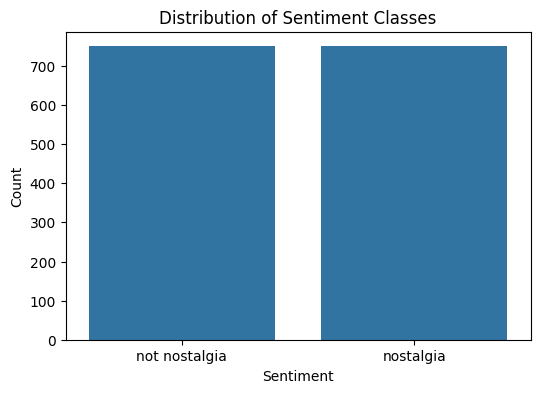

In [3]:
# Step 2: Data Visualizations
# Visualization of the distribution of sentiments
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='sentiment')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


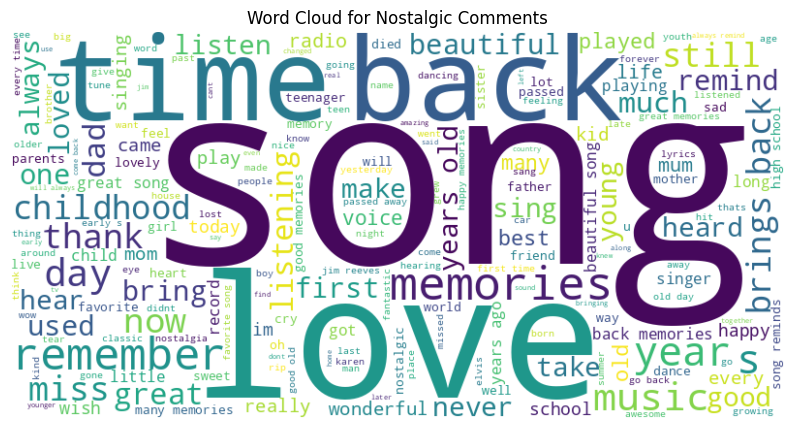

In [4]:
# Word cloud for the most frequent words in nostalgic comments
nostalgic_comments = ' '.join(data[data['sentiment'] == 'nostalgia']['cleaned_comment'])
wordcloud_nostalgia = WordCloud(width=800, height=400, background_color='white').generate(nostalgic_comments)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_nostalgia, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Nostalgic Comments')
plt.show()


/tmp/ipykernel_14270/1745196600.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='sentiment', y='word_count', data=data, ci=None)


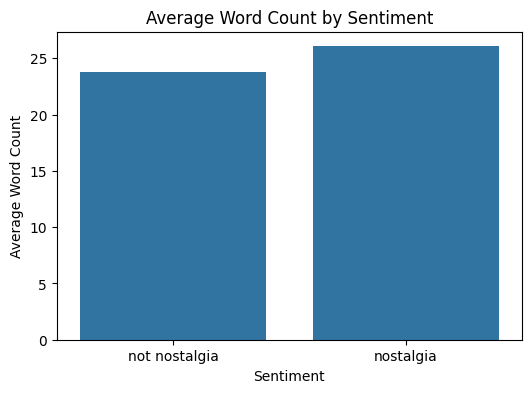

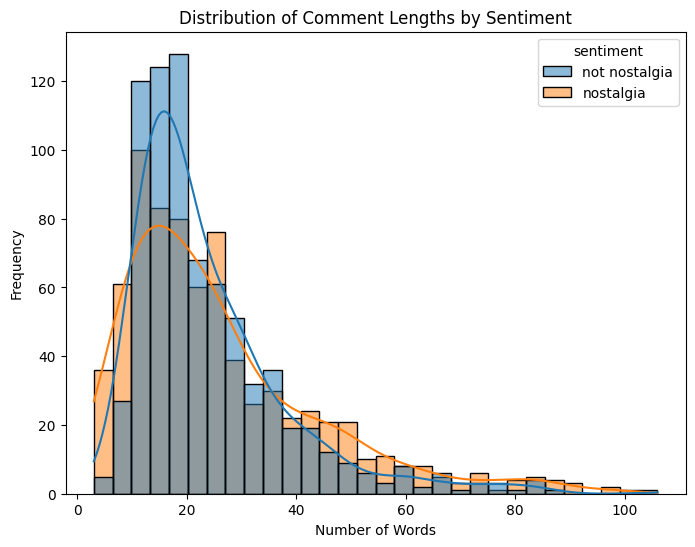

In [5]:
# Bar plot of the average word count for each sentiment
data['word_count'] = data['cleaned_comment'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.barplot(x='sentiment', y='word_count', data=data, ci=None)
plt.title('Average Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')
plt.show()

# Histogram of comment lengths for each sentiment
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='word_count', hue='sentiment', bins=30, kde=True)
plt.title('Distribution of Comment Lengths by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


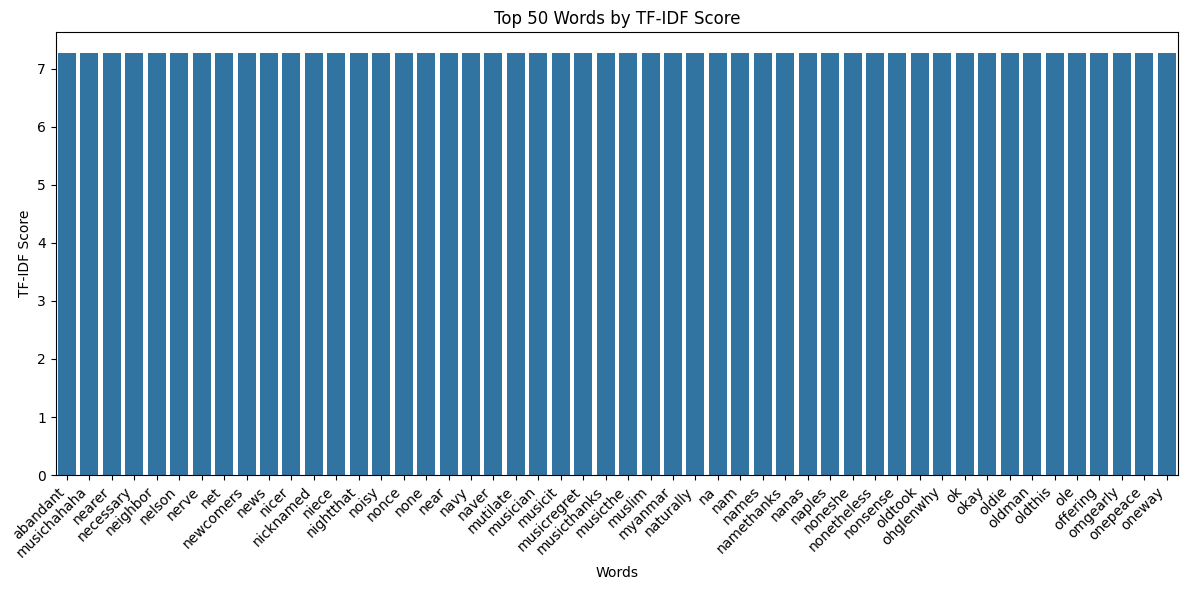

In [6]:
# Step 3: Generate TF-IDF Features
X = data['cleaned_comment']
y = data['sentiment_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create TF-IDF Vectorizer for feature extraction
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

# Visualizing top 50 words by their TF-IDF score
tfidf_scores = pd.DataFrame(
    tfidf_vect.idf_, index=tfidf_vect.get_feature_names_out(), columns=["idf_weights"]
).sort_values(by="idf_weights", ascending=False).head(50)

plt.figure(figsize=(12, 6))
sns.barplot(x=tfidf_scores.index, y="idf_weights", data=tfidf_scores)
plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()


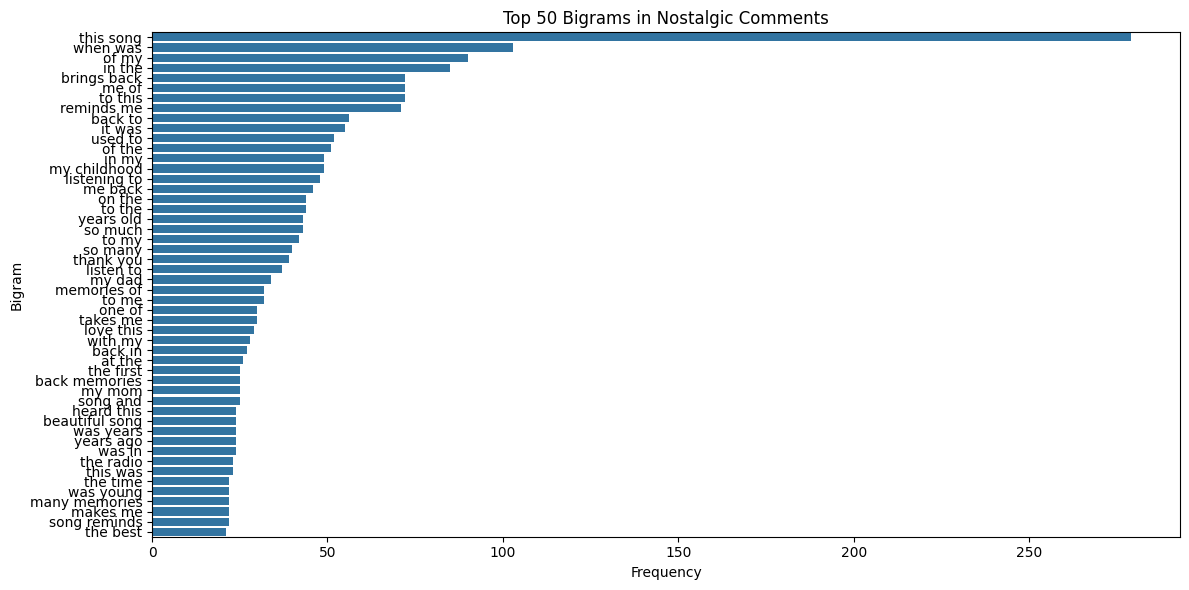

In [7]:
# Bigram frequency for nostalgia class
bigram_vect = CountVectorizer(ngram_range=(2, 2))
nostalgic_bigrams = bigram_vect.fit_transform(data[data['sentiment'] == 'nostalgia']['cleaned_comment'])
bigram_counts = pd.DataFrame(
    nostalgic_bigrams.toarray(), columns=bigram_vect.get_feature_names_out()
).sum().sort_values(ascending=False).head(50)

plt.figure(figsize=(12, 6))
sns.barplot(x=bigram_counts.values, y=bigram_counts.index)
plt.title('Top 50 Bigrams in Nostalgic Comments')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()


In [8]:
# Step 4: Train Naive Bayes classifiers with both TF-IDF and Count features
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# Naive Bayes classifier for TF-IDF features
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Naive Bayes classifier for Count features
nb_count = MultinomialNB()
nb_count.fit(X_train_counts, y_train)
y_pred_count = nb_count.predict(X_test_counts)


In [9]:
# Step 5: Evaluate the performance of both models
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
accuracy_count = accuracy_score(y_test, y_pred_count)

report_tfidf = classification_report(y_test, y_pred_tfidf, target_names=['not nostalgia', 'nostalgia'], digits=4)
report_count = classification_report(y_test, y_pred_count, target_names=['not nostalgia', 'nostalgia'], digits=4)

print("TF-IDF Model Accuracy:", accuracy_tfidf)
print("TF-IDF Model Classification Report:\n", report_tfidf)
print("Count Vectorizer Model Accuracy:", accuracy_count)
print("Count Vectorizer Model Classification Report:\n", report_count)


TF-IDF Model Accuracy: 0.8622222222222222
TF-IDF Model Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.9223    0.7911    0.8517       225
    nostalgia     0.8171    0.9333    0.8714       225

     accuracy                         0.8622       450
    macro avg     0.8697    0.8622    0.8615       450
 weighted avg     0.8697    0.8622    0.8615       450

Count Vectorizer Model Accuracy: 0.8511111111111112
Count Vectorizer Model Classification Report:
                precision    recall  f1-score   support

not nostalgia     0.9115    0.7778    0.8393       225
    nostalgia     0.8062    0.9244    0.8613       225

     accuracy                         0.8511       450
    macro avg     0.8588    0.8511    0.8503       450
 weighted avg     0.8588    0.8511    0.8503       450

